 System that predicts the final grades in specific subject based on the student previous exam grade and number of study hours.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
def generate_student_data(num_students=3000):
    np.random.seed(42)  # For reproducibility

    # Generating feature data
    study_hours = np.random.randint(1, 12, num_students)
    previous_grade = np.random.randint(65, 101, num_students)

    # Creating a DataFrame to store synthetic data
    data = pd.DataFrame({
        'Study_Hours': study_hours,
        'Previous_Exam_Grades': previous_grade,
    })

    # Generating a synthetic final grade based on the features with custom coefficients
    coefficient_hours_studied = 4
    coefficient_previous_grade = 0.7

    data['Final_Grade'] = (data['Study_Hours'] * coefficient_hours_studied) + \
                          (data['Previous_Exam_Grades'] * coefficient_previous_grade)

    # Adding some variability or noise to the final grade
    data['Final_Grade'] += np.random.uniform(-5, 5, num_students)
    
    # Cap the final grade at 100
    data['Final_Grade'] = np.minimum(data['Final_Grade'], 100)
    
    # Ensure the final grade is not less than 0
    data['Final_Grade'] = np.maximum(data['Final_Grade'], 60)

    # Categorizing grades
    thresholds = [0, 74, 80, 85, 90, 100]  # Example thresholds for categorization
    labels = ['Fail', 'Average', 'Good', 'Very Good', 'Excellent']
    data['Grade_Category'] = pd.cut(data['Final_Grade'], bins=thresholds, labels=labels, right=False)
    
    return data

# Generate synthetic data and save it to Excel
student_data = generate_student_data(num_students=3000)
student_data.to_excel('student_performance_data.xlsx', index=False)


In [5]:
def perform_eda(data):
    plt.figure(figsize=(12, 8))

    # Pairplot for numerical features
    sns.pairplot(data[['Study_Hours', 'Previous_Exam_Grades', 'Final_Grade']])
    plt.title('Pairplot of Numerical Features')
    plt.show()

    # Visualizing the distribution of Previous Exam Grades and Final Grade
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data['Previous_Exam_Grades'], kde=True)
    plt.xlabel('Previous Exam Grades')
    plt.ylabel('Number of Students')
    plt.title('Distribution of Previous Exam Grades')

    plt.subplot(1, 2, 2)
    sns.histplot(data['Final_Grade'], kde=True)
    plt.xlabel('Final Grade')
    plt.ylabel('Number of Students')
    plt.title('Distribution of Final Grade')

    plt.tight_layout()
    plt.show()

    # Interpretation of visualizations
    print("\nNumber of students with different ranges of previous exam grade:")
    score_bins = [0, 60, 70, 80, 90, 100]
    print(pd.cut(data['Previous_Exam_Grades'], bins=score_bins).value_counts())

    print("\nNumber of students with different ranges of final grades:")
    grade_bins = [60, 70, 80, 85, 90, 100]
    print(pd.cut(data['Final_Grade'], bins=grade_bins).value_counts())

    return


In [6]:
def train_linear_regression(data):
    X = data[['Study_Hours', 'Previous_Exam_Grades']]
    y = data['Final_Grade']  # Assuming 'Final_Grade' is the target variable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    joblib.dump(model, 'trained_linear_regression_model.pkl')

    return model, X_test, y_test


<Figure size 1200x800 with 0 Axes>

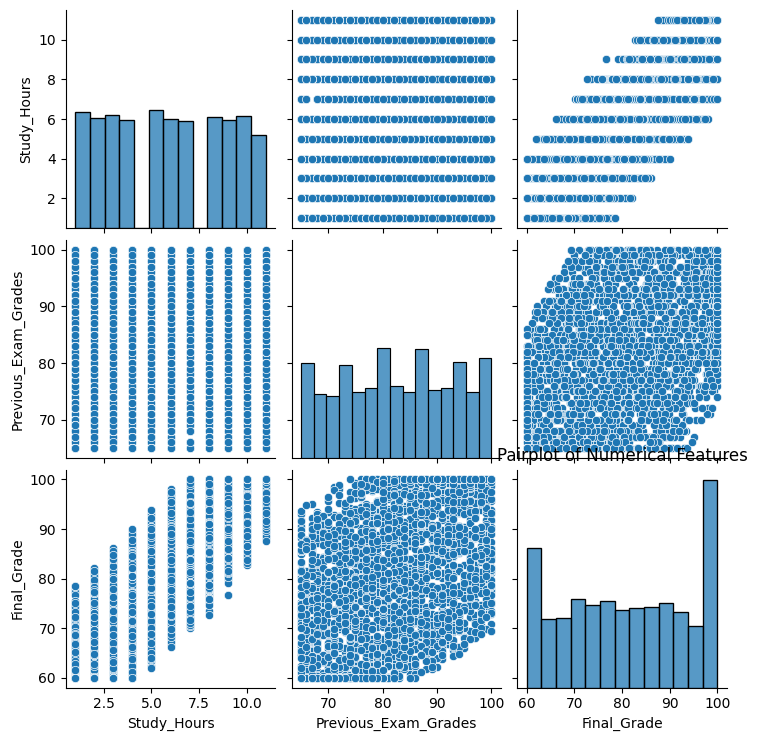

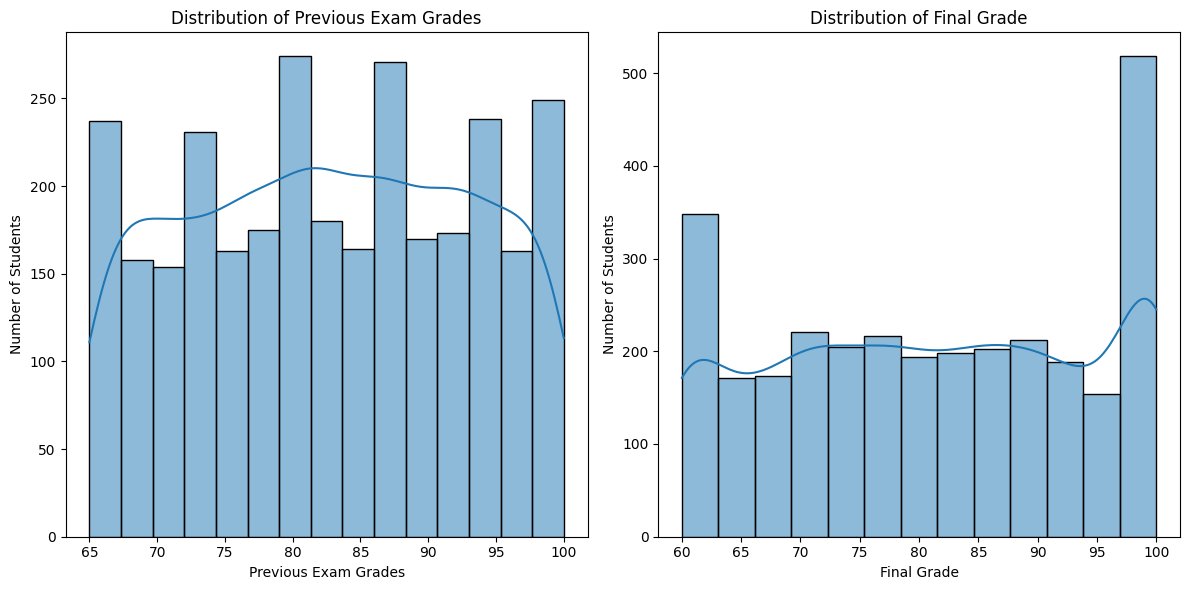


Number of students with different ranges of previous exam grade:
Previous_Exam_Grades
(80, 90]     890
(90, 100]    823
(70, 80]     810
(60, 70]     477
(0, 60]        0
Name: count, dtype: int64

Number of students with different ranges of final grades:
Final_Grade
(90, 100]    910
(70, 80]     678
(60, 70]     520
(85, 90]     341
(80, 85]     327
Name: count, dtype: int64


In [7]:
def simulation(num_students=3000):
    # Generate synthetic data
    student_data = generate_student_data(num_students)

    # Perform Exploratory Data Analysis
    perform_eda(student_data)

    # Train the linear regression model
    trained_model, X_test, y_test = train_linear_regression(student_data)

    # Evaluate the model
    test_predictions = trained_model.predict(X_test)

    # Create a DataFrame to hold test predictions and actual values for comparison
    evaluation_results = pd.DataFrame({'Predicted_Grade': test_predictions, 'Actual_Grade': y_test})

    return trained_model, evaluation_results, student_data

# Run the simulation
model, evaluation_results, generated_data = simulation(num_students=3000)


Mean Absolute Error (MAE): 2.5102297103441766
Mean Squared Error (MSE): 9.342125390009137
R-squared: 0.9450731012046665


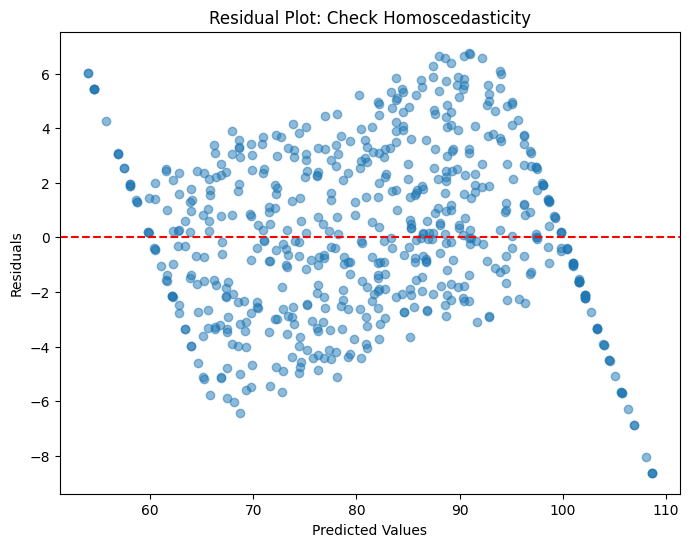

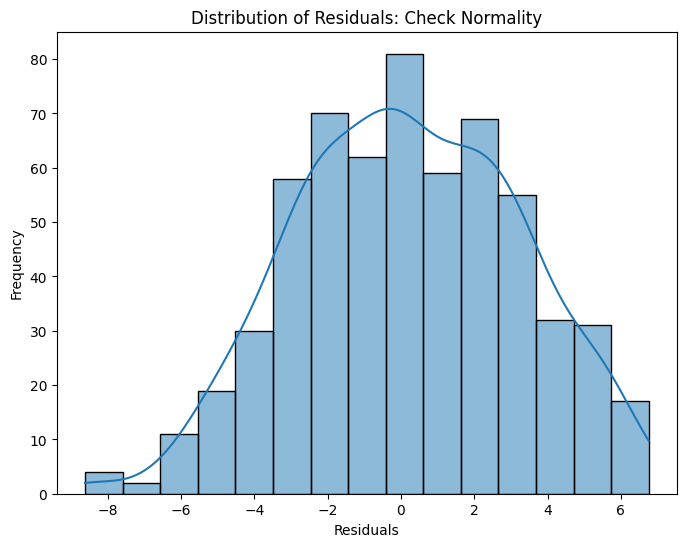

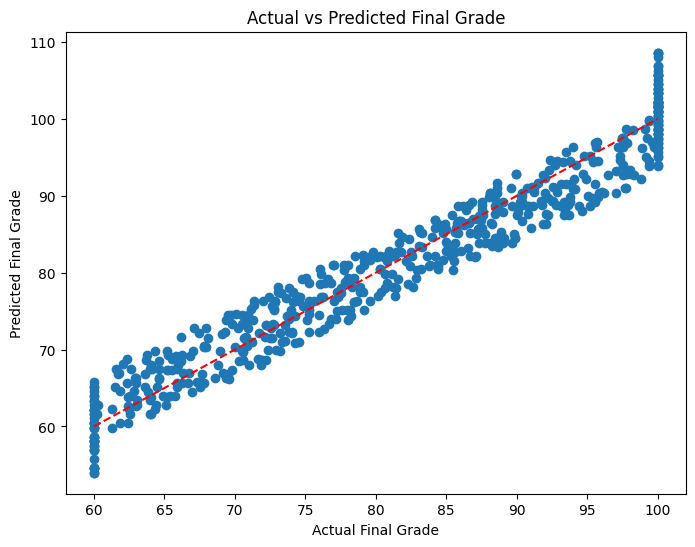

In [11]:
# Define class labels
class_labels = ['Fail', 'Average', 'Good', 'Very Good', 'Excellent']

# Function to load generated data
def load_generated_data(file_path):
    return pd.read_excel(file_path)


# Function to evaluate the classification model
def evaluate_regression_model(model, X_test, y_test):
    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r_squared}")

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot: Check Homoscedasticity')
    plt.show()

    # Distribution of residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals: Check Normality')
    plt.show()

    # Predicted vs Actual plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
    plt.xlabel("Actual Final Grade")
    plt.ylabel("Predicted Final Grade")
    plt.title("Actual vs Predicted Final Grade")
    plt.show()

    return mae, mse, r_squared


# Load generated data, train the model, and perform evaluation
def evaluation_and_analysis(file_path):
    # Load generated data
    student_data = load_generated_data(file_path)

    # Train the regression model and get the model, test data
    model, X_test, y_test = train_linear_regression(student_data)

    # Evaluate the regression model
    evaluate_regression_model(model, X_test, y_test)

# Example usage
evaluation_and_analysis('student_performance_data.xlsx')
